In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

In [6]:
S_all = pd.read_csv("STOXX50E_1Aug2022_3Nov2023.csv")
S_all = S_all[['Date', 'Adj Close']]

In [7]:
dt = 1/252

In [11]:
# Define a function for this "window" later
window = 252
history_data = list(S_all.iloc[7:7+window]['Adj Close'])
log_history_data = np.log(history_data)
log_return = log_history_data[1:] - log_history_data[:-1]

In [12]:
v = np.mean(log_return)/dt
sigma = np.std(log_return)/np.sqrt(dt)
print(f"v: {v}")
print(f"Sigma: {sigma}")

v: 0.1395568828098834
Sigma: 0.17080938010226537


### Exact GBM Simulation

In [13]:
def simGBMExact(Nsim, S0, v, sigma, dt, T):
    m = int(T/dt)
    S = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
    for i in tqdm(range(Nsim)):
        Z = np.random.normal(size=m)
        for j in range(1, m+1):
            S[i][j] = S[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*Z[j-1])
    return S

In [14]:
# put as 1 first
sim_S = simGBMExact(10, history_data[-1], v, sigma, dt, 1)

100%|██████████| 10/10 [00:00<00:00, 1248.16it/s]


In [15]:
len(sim_S[0])

253

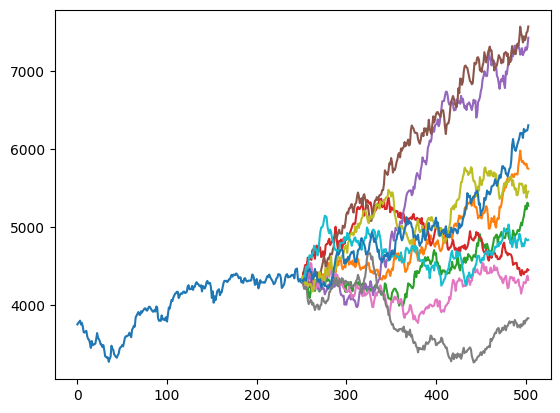

In [16]:
plot1 = pd.Series(history_data, index=np.arange(len(history_data)))
plt.plot(plot1)
for i in range(len(sim_S)):
    plot2 = pd.Series(sim_S[i], index=np.arange(len(history_data)-1, len(history_data)-1+len(sim_S[0])))
    plt.plot(plot2)
plt.show()

### Payoff Function

In [17]:
def payoff(Spath, initial=3487.05, V=1743.525, parti=1.5, denom=1000):
    m = len(Spath)
    Smin = min(Spath)
    if Smin > V:
        payoff = max(denom, denom*(1+parti*(Spath[m-1]/initial-1)))
    else:
        payoff = denom*(Spath[m-1]/initial)
    return payoff

# Risk-Neutral Valuation

In [18]:
ir = pd.read_csv("euro_area_1_year_yield_curve.csv")

In [24]:
r = ir[ir['DATE']=='2023-08-09'].iloc[0, 2]/100
v = r-sigma**2/2
St = history_data[-1]
Nsim=100000
T = 485/252
print(f"r: {r}")
print(f"v: {v}")

r: 0.033256009999999996
v: 0.01866808783453991


### Normal Monte Carlo Simulation

In [25]:
sim_S = simGBMExact(Nsim, St, v, sigma, dt, T)

100%|██████████| 100000/100000 [01:42<00:00, 975.52it/s]


#### Plot 50 random simulated path

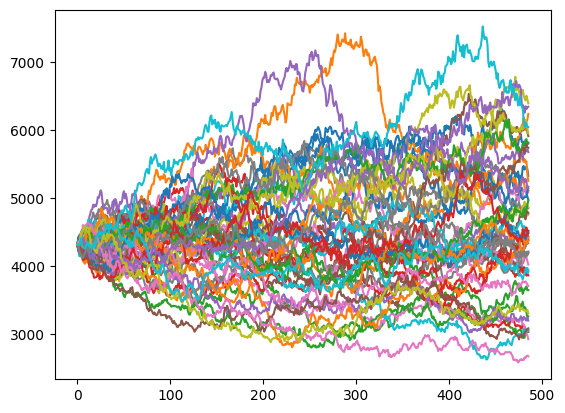

In [26]:
for i in range(len(sim_S[50:100])):
    plot3 = pd.Series(sim_S[i])
    plt.plot(plot3)
plt.show()

In [27]:
sim_S_df = pd.DataFrame(sim_S)

In [28]:
sim_Note = np.exp(-r*T)*sim_S_df.apply(payoff, axis=1)
note_MC = np.mean(sim_Note)
note_MC_var = np.var(sim_Note)/Nsim
lower_percentile = note_MC-1.96*np.sqrt(note_MC_var)
higher_percentile = note_MC+1.96*np.sqrt(note_MC_var)

In [29]:
print(f"Note Value (MC): {note_MC}")
print(f"Estimate Variance: {note_MC_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (MC): 1412.5122672709367
Estimate Variance: 1.7331668612767348
95% Confidence Interval: [1409.9319312822947, 1415.0926032595787]


### Antithetic Variate Simulation

In [30]:
def simGBMExactAV(Nsim, S0, v, sigma, dt, T, collate=False):
    m=int(T/dt)
    S = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
    Stilde = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
    for i in tqdm(range(Nsim)):
        Z = np.random.normal(size=m)
        for j in range(1, m+1):
            S[i][j] = S[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*Z[j-1])
            Stilde[i][j] = Stilde[i][j-1]*np.exp(v*dt+sigma*np.sqrt(dt)*(-Z[j-1]))
    if collate:
        output = []
        for i in range(Nsim):
            output.append(S[i])
            output.append(S[i])
        return output
    else:
        return S+Stilde

In [31]:
sim_S_AV = simGBMExactAV(int(Nsim/2), St, v, sigma, dt, T, collate=False)
sim_S_AV_df = pd.DataFrame(sim_S_AV)

100%|██████████| 50000/50000 [01:50<00:00, 451.78it/s]


In [32]:
sim_Note_AV = np.exp(-r*T)*sim_S_AV_df.apply(payoff, axis=1)
note_AV = np.mean(sim_Note_AV)
note_AV_var = np.var(sim_Note_AV)/Nsim
lower_percentile = note_AV-1.96*np.sqrt(note_AV_var)
higher_percentile = note_AV+1.96*np.sqrt(note_AV_var)

In [33]:
print(f"Note Value (AV): {note_AV}")
print(f"Estimate Variance: {note_AV_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (AV): 1410.024750729598
Estimate Variance: 1.7108932794372858
95% Confidence Interval: [1407.4610487924988, 1412.5884526666973]


### Control Variate Simulation

In [34]:
def simGBMExactCV(Nsim, S0, v, sigma, dt, T):
    small_n = 1000
    sim_S_pre = simGBMExact(small_n, S0, v, sigma, dt, T)
    sim_S_pre_df = pd.DataFrame(sim_S_pre)
    sim_Note_pre = np.exp(-r*T)*sim_S_pre_df.apply(payoff, axis=1)
    c = -np.cov(sim_Note_pre, [sub[len(sim_S_pre[0])-1] for sub in sim_S_pre])[0][1]/(S0**2*np.exp(2*r*T)*(np.exp(sigma**2*T)-1))
    print(f"c: {c}")
    
    sim_S_CV = simGBMExact(Nsim, S0, v, sigma, dt, T)
    sim_S_CV_df = pd.DataFrame(sim_S_CV)
    X = np.exp(-r*T)*sim_S_CV_df.apply(payoff, axis=1)
    sim_note_CV = X + c*([sub[len(sim_S_CV[0])-1] for sub in sim_S_CV]-S0*np.exp(r*T))
    return sim_note_CV

In [35]:
sim_Note_CV = simGBMExactCV(Nsim, St, v, sigma, dt, T)

100%|██████████| 1000/1000 [00:01<00:00, 915.82it/s]


c: -0.3660681035062056


100%|██████████| 100000/100000 [01:45<00:00, 950.56it/s]


In [36]:
note_CV = np.mean(sim_Note_CV)
note_CV_var = np.var(sim_Note_CV)/Nsim
lower_percentile = note_CV-1.96*np.sqrt(note_CV_var)
higher_percentile = note_CV+1.96*np.sqrt(note_CV_var)

In [37]:
print(f"Note Value (CV): {note_CV}")
print(f"Estimate Variance: {note_CV_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (CV): 1411.121022505108
Estimate Variance: 0.039413388124424895
95% Confidence Interval: [1410.7319075197645, 1411.5101374904514]


### Stratified Sampling Simulation (not feasible given payoff function)

In [ ]:
def simGBMExactSS(stratraNo, Nsim, S0, v, sigma, dt, T):
    N=int(Nsim/stratraNo)
    m=int(T/dt)

    S = [[S0 for _ in range(m+1)] for _ in range(Nsim)]
    for i in tqdm(range(stratraNo)):
        for j in tqdm(range(N)):
            V = (np.random.uniform(size=m)+i)/stratraNo
            Z = scipy.stats.norm.ppf(V)
            for k in range(1, m+1):
                S[j+i*N][k] = S[j+i*N][k]*np.exp(v*dt+sigma*np.sqrt(dt)*Z[k-1])
    return S

In [39]:
sim_S_SS = simGBMExactSS(100, Nsim, St, v, sigma, dt, T)
sim_S_SS_df = pd.DataFrame(sim_S_SS)

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


In [40]:
sim_Note_SS = np.exp(-r*T)*sim_S_SS_df.apply(payoff, axis=1)
note_SS = np.mean(sim_Note_SS)
note_SS_var = np.var(note_SS)/Nsim
lower_percentile = note_SS-1.96*np.sqrt(note_SS_var)
higher_percentile = note_SS+1.96*np.sqrt(note_SS_var)

In [41]:
print(f"Note Value (SS): {note_SS}")
print(f"Estimate Variance: {note_SS_var}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")

Note Value (SS): 1273.23599561361
Estimate Variance: 0.0
95% Confidence Interval: [1273.23599561361, 1273.23599561361]


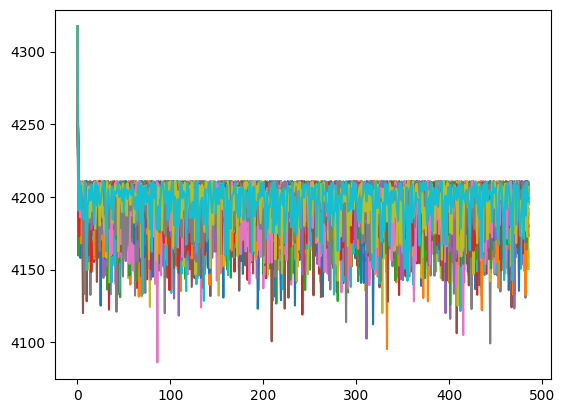

In [47]:
for i in range(len(sim_S[20000:20050])):
    plot3 = pd.Series(sim_S_SS[i])
    plt.plot(plot3)
plt.show()

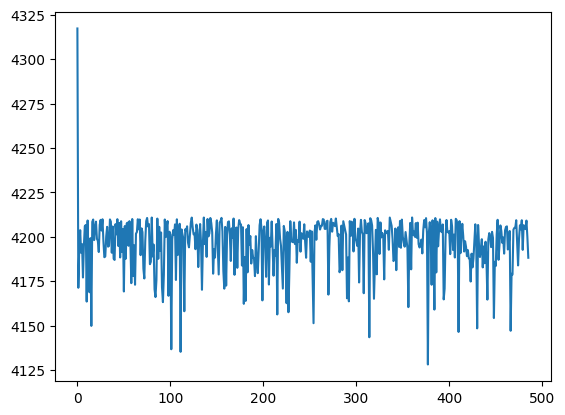

In [43]:
plot3 = pd.Series(sim_S_SS[1])
plt.plot(plot3)

### Importance Sampling Simulation